In [40]:
%load_ext autoreload
%autoreload
%matplotlib widget

In [2]:
import flammkuchen as fl
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import re
from scipy import stats
import os
import math

from luminance_analysis import PooledData
from matplotlib.gridspec import GridSpec
from luminance_analysis.utilities import nanzscore

plt.style.use("figures.mplstyle")

In [3]:
from bouter.utilities import extract_segments_above_threshold
import seaborn as sns
from luminance_analysis.plotting import make_bar, get_yg_custom_cmap, add_offset_axes, shade_plot, stim_plot

# %autoreload

In [ ]:
fig_fold = Path(r"C:\Users\otprat\Documents\figures\luminance\manuscript_figures\fig1supp")

if not os.path.isdir(fig_fold):
    os.mkdir(fig_fold)

### Define functions

In [4]:
def calculate_total_vel(x_vel, y_vel):  
    return(np.sqrt((x_vel**2)+(y_vel**2)))

def crop_intervals_from_mat(data_mat, timepoints, dt, window):
    cropped_mat = np.empty((data_mat.shape[0]*len(timepoints), int(window/dt), data_mat.shape[2]))
    
    for fish in range(data_mat.shape[2]):
        for stim_rep in range(data_mat.shape[0]):
            for timepoint in range(len(timepoints)):
                if timepoints[timepoint][0] < 0:
                    cropped_interval = data_mat[stim_rep, timepoints[timepoint][0]:, fish]
                else:
                    cropped_interval = data_mat[stim_rep, timepoints[timepoint][0]:timepoints[timepoint][0]+int(window/dt), fish]
                cropped_mat[timepoint + len(timepoints)*stim_rep, :, fish] = cropped_interval   
    return(cropped_mat)

def smooth_df(df, window, omit_col=None):       
    extended_df = pd.DataFrame(np.concatenate((df.values[-window//2:, :], df.values, df.values[:window//2, :])))
    smoothed_extended_df = extended_df.rolling(window+1, center=True).mean()
    smoothed_df = pd.DataFrame(smoothed_extended_df.values[window//2:-window//2, :], index=df.index, columns=df.columns)
    
    if omit_col is not None:
        smoothed_df[omit_col] = df[omit_col]
    
    return(smoothed_df)

In [5]:
#Necessary functions from old bouter

def resample(df_in, resample_sec=0.005):
    """
    Parameters
    ----------
    df_in :

    resample_sec :

    fill_nan: int
        If a number is passed, NaNs will be filled with it before interpolation

    Returns
    -------
    """
    df = df_in.copy()
    t_index = pd.to_timedelta(
        (df["t"].to_numpy() * 10e5).astype(np.uint64), unit="us"
    )
    df.set_index(t_index - t_index[0], inplace=True)
    df = df.resample("{}ms".format(int(resample_sec * 1000))).mean()
    df.index = df.index.total_seconds()
    return df.interpolate().drop("t", axis=1)

    
def find_phase_col(exp):
    """
    Find the name of the stimulus_param_log df where phase data is stored

    Returns
    -------
    string
        Name of the DataFrame column
    """
    phase_col = next(col for col in exp.stimulus_log.columns if col.endswith('_current_phase'))
    return phase_col


def get_n_reps(exp):
    """
    Find number of shuffled repetitions per stimulation loop

    Returns
    -------
    int
        Number of shuffled repetitions per stimulation loop
    """
    try:
        n_reps = exp['stimulus']['protocol'][next(iter(exp['stimulus']['protocol'].keys()))]['shuffled_reps']
    except KeyError:
        n_reps = 1

    return n_reps


def get_rep_t_intervals(exp, phases_per_rep, use_resampled_df=True, use_phases=False):
    """
    Get starting and ending timepoints for each shuffled stimulus repetition

    Parameters
    ----------
    phases_per_rep : int
        Number of phases of which the presented stimulus consists
    use_resampled_df : bool
        Indicates whether the DataFrame should be resampled

    Returns
    -------
    list of tuples
        Starting and ending timepoints for each stimulus repetition
    """
    if use_resampled_df:
        stimulus_log = resample(exp.stimulus_log)
    else:
        stimulus_log = exp.stimulus_log

    phase_col = find_phase_col(exp)
    if not use_phases:
        n_shuffled_reps = get_n_reps(exp)
    else:
        n_shuffled_reps = int((np.unique(exp.stimulus_log[find_phase_col(exp)]).shape[0])/phases_per_rep)
        
    t_rep_intervals = []

    for i_shuffled_rep in range(n_shuffled_reps):
        rep_phases = [phase + phases_per_rep * i_shuffled_rep for phase in range(phases_per_rep)]

        idx_start_t = stimulus_log[stimulus_log[phase_col] == rep_phases[0]].index.to_list()[0]
        idx_end_t = stimulus_log[stimulus_log[phase_col] == rep_phases[-1]].index.to_list()[-1]

        if use_resampled_df:
            t_rep_intervals.append((idx_start_t, idx_end_t))
        else:
            t_rep_intervals.append((stimulus_log.iloc[idx_start_t]['t'], stimulus_log.iloc[idx_end_t]['t']))

    return t_rep_intervals

def get_stim_arr(exp, phases_per_rep, stim_name, resample_df=True):
    """
    Get stimulus array with timestamps and stimulation variable

    Parameters
    ----------
    phases_per_rep : int
        Number of phases of which the presented stimulus consists
    stim_name : str
        Name of the DataFrame column containing the stimulation variable
    resample_df : bool
        Indicates whether the stimulus array should be resampled

    Returns
    -------
    array
        Stimulus array
    """
    phase_col = find_phase_col(exp)
    first_rep = exp.stimulus_log[exp.stimulus_log[phase_col] < phases_per_rep]

    if resample_df:
        first_rep = resample(first_rep)
    else:
        pass

    stim = first_rep.index.values
    stim = np.vstack([stim, first_rep[stim_name].values])

    return stim

def crop_reps_from_df(df, cropping_idxs, data_cols, n_timepoints, use_resampled_df=True, out_format='dict'):
    """
    Crop a Dataframe into the multiple repetitions of the stimulus

    Parameters
    ----------
    df : pandas DataFrame
        DataFrame with the complete data
    cropping_idxs : list of tuples
        Starting and ending indexes for each stimulus repetition
    data_cols : list of str
        Names of the DataFrame columns from which we want to crop the data
    n_timepoints : int
        number of timepoints into which the data should be resampled
    use_resampled_df : bool
        Indicates whether the input DataFrame has been previously resampled (and timepoints correspond to indexes)
    out_format : str
        Indicates the type of output data. 'list' for list of dataframes, one for each repetition,
        'dict' for dictionary of arrays, one for each parameter specified in data_cols.

    Returns
    -------
    dict of arrays
        Dictionary of arrays for each column in data_cols. Dimensions being (stimulation repetitions x timepoints)
    list of dataframes
        List of pandas dataframes for each repetition in cropping_idxs.
    """
    if out_format == 'dict':
        data_dict = {}

        for col in data_cols:
            data_arr = np.empty((len(cropping_idxs), n_timepoints))
            for rep in range(len(cropping_idxs)):
                if use_resampled_df:
                    rep_raw_t = df[cropping_idxs[rep][0]:cropping_idxs[rep][1]].index.values
                else:
                    rep_raw_t = df[cropping_idxs[rep][0]:cropping_idxs[rep][1]]['t'].values
                rep_raw_data = df[cropping_idxs[rep][0]:cropping_idxs[rep][1]][col].values
                data_arr[rep, :] = np.interp(np.linspace(rep_raw_t[0], rep_raw_t[-1], n_timepoints), rep_raw_t,
                                             rep_raw_data)
            data_dict[col] = data_arr

        output_data = data_dict

    elif out_format == 'list':
        data_list = []

        for rep in range(len(cropping_idxs)):
            data_list.append(df[data_cols][cropping_idxs[rep][0]:cropping_idxs[rep][1]])

        output_data = data_list

    return output_data


### Load data

In [6]:
import bouter
# %autoreload

In [7]:
#Classic luminance
phases_per_rep = 18

### Pooled fish

#### Swimming velocity analysis

In [8]:
smoothing = True
method = 'LFF'#'LFF' #'rolling median'
window_size = 20

fill_nans = True
fill_val = 0

In [9]:
#Select datasets to load
datasets = ['pilot']
master_path = Path(r'\\portulab.synology.me\legacy\experiments\E0032_luminance\neat_exps\freely_swimming_beh')

#Define bout extraction parameters
threshold = .25
min_length = 20

In [10]:
#And load them
dataset_dict = {'vel_mat':{}, 'prob_mat':{}}
stimulus_arr = np.array([])
mat_len = 0

#Load dataset velocities
all_fish_mat = np.array([])

for experiment in list(master_path.glob("*_f[0-9]")):

    print('Working on ' + str(experiment))
    print('Loading data')
    exp = bouter.free.FreelySwimmingExperiment(experiment)
    idx_rep_intervals = get_rep_t_intervals(exp, phases_per_rep, use_phases=True)
    
    stim_arr = get_stim_arr(exp, phases_per_rep, 'flash_luminance')
    experiment_dict = {}
    
    #Get stimulus array
    if stimulus_arr.shape[0] == 0:
        stimulus_arr = stim_arr
    else:
        pass

    n_fish = exp['general']['program_version']['arguments']['tracking']['tracking_params']['n_max_fish']
    print('{} fish detected'.format(n_fish))

    print('Computing velocities')
    vel_data_cols = []
    for fish in range(n_fish):
        for dim in ['x', 'y']:
            vel_data_cols.append('f{}_v{}'.format(fish, dim))  

    #Smooth dataset if desired
    if smoothing:
        if method == 'rolling median':
            behavior_df = exp.behavior_log.rolling(window=window_size, min_periods=1).median()
        elif method == 'LFF':
            behavior_df = smooth_df(exp.behavior_log, window_size, omit_col='t')       
    else:
        behavior_df = exp.behavior_log  

    #Fill NaNs
    if fill_nans:
        behavior_df = behavior_df.fillna(value=fill_val)

    #Get velocities
    experiment_dict = crop_reps_from_df(resample(behavior_df), idx_rep_intervals, vel_data_cols, stim_arr.shape[1])

    for fish in range(n_fish):
        fish_vel = calculate_total_vel(experiment_dict['f{}_vx'.format(fish)], experiment_dict['f{}_vy'.format(fish)])

        #Set n_timepoints for data across all datasets
        if mat_len == 0:
            mat_len = fish_vel.shape[1]
        else:
            pass

        #Stack data if same length, pad if shorter, crop if longer.
        if fish_vel.shape[1] == mat_len:
            if all_fish_mat.shape[0] == 0:
                all_fish_mat = fish_vel
            else:
                all_fish_mat = np.dstack((all_fish_mat, fish_vel))
            print('Data size matches perfectly')
        elif fish_vel.shape[1] > mat_len:
            if all_fish_mat.shape[0] == 0:
                all_fish_mat = fish_vel[:, :mat_len]
            else:
                all_fish_mat = np.dstack((all_fish_mat, fish_vel[:, :mat_len]))
            print('Cropped velocity data from {} to {} datapoints'.format(fish_vel.shape[1], mat_len))
        else:
            n_pad = ((0,0), (0, mat_len-fish_vel.shape[1]))
            if all_fish_mat.shape[0] == 0:
                all_fish_mat = np.pad(fish_vel, pad_width=n_pad, mode='edge')
            else:
                all_fish_mat = np.dstack((all_fish_mat, np.pad(fish_vel, pad_width=n_pad, mode='edge')))
            print('Extended velocity data from {} to {} datapoints'.format(fish_vel.shape[1], mat_len)) 
    print('Velocities computed')

Working on \\portulab.synology.me\legacy\experiments\E0032_luminance\neat_exps\freely_swimming_beh\190702_f1
Loading data
3 fish detected
Computing velocities
Data size matches perfectly
Data size matches perfectly
Data size matches perfectly
Velocities computed
Working on \\portulab.synology.me\legacy\experiments\E0032_luminance\neat_exps\freely_swimming_beh\190702_f2
Loading data
3 fish detected
Computing velocities
Data size matches perfectly
Data size matches perfectly
Data size matches perfectly
Velocities computed
Working on \\portulab.synology.me\legacy\experiments\E0032_luminance\neat_exps\freely_swimming_beh\190702_f3
Loading data
3 fish detected
Computing velocities
Cropped velocity data from 21188 to 21186 datapoints
Cropped velocity data from 21188 to 21186 datapoints
Cropped velocity data from 21188 to 21186 datapoints
Velocities computed
Working on \\portulab.synology.me\legacy\experiments\E0032_luminance\neat_exps\freely_swimming_beh\190702_f4
Loading data
3 fish detecte

In [11]:
#Extract bouts
print('Extracting dataset bouts')
all_fish_bouts = np.zeros_like(all_fish_mat)

for fish in range(all_fish_mat.shape[2]):
    for rep in range(all_fish_mat.shape[0]):
        try:
            bouts, cont = extract_segments_above_threshold(all_fish_mat[rep, :, fish], threshold=threshold, min_length=min_length)
        except IndexError:
                    print('No bouts found in fish {}, repetition {}'.format(fish, rep))

        for i_bout in range(len(bouts)):
            all_fish_bouts[rep, bouts[i_bout][0]:bouts[i_bout][1], fish] = 1    

#Store dataset velocities and bouts
dataset_dict['vel_mat'] = all_fish_mat
dataset_dict['prob_mat'] = all_fish_bouts

print('Done!')

Extracting dataset bouts
No bouts found in fish 1, repetition 3
No bouts found in fish 2, repetition 29
Done!


In [12]:
#Normalize bout probability datasets
normalize = 'fishwise' #'trialwise' #'fishwise'
method = None #'zscore' #'substract' #'divide' #'zscore'

prob_mat = dataset_dict['prob_mat']
norm_prob_mat = np.empty_like(prob_mat)

if normalize == 'trialwise':
    for fish in range(prob_mat.shape[2]):
        for rep in range(prob_mat.shape[0]):
            if method == 'substract': #Substract mean
                norm_rep = prob_mat[rep, :, fish] - np.nanmean(prob_mat[rep, :, fish])
            elif method == 'divide': #Divide mean
                norm_rep = prob_mat[rep, :, fish] / np.nanmean(prob_mat[rep, :, fish])
            elif method == 'zscore': #Zscore
                norm_rep = nanzscore(prob_mat[rep, :, fish])

            norm_prob_mat[rep, :, fish] = norm_rep

elif normalize == 'fishwise':
    for fish in range(prob_mat.shape[2]):
        norm_fish = prob_mat[:, :, fish] - np.nanmean(prob_mat[:, :, fish])
        norm_prob_mat[:, :, fish] = norm_fish

dataset_dict['norm_prob_mat'] = norm_prob_mat

In [13]:
stim_arr = stimulus_arr

### Bout probability

In [14]:
use_normalized_bout_mat = True

if use_normalized_bout_mat:
    prob_mat = dataset_dict['norm_prob_mat']
else:
    prob_mat = dataset_dict['prob_mat']

In [15]:
#Get average bout probability for each fish
fish_mean_bout_prob = np.empty((prob_mat.shape[2], prob_mat.shape[1]))

for fish in range(prob_mat.shape[2]):     
    fish_mean_bout_prob[fish, :] = np.nanmean(prob_mat[:, :, fish], 0)

In [16]:
def plot_bout_prob(bout_prob_mat, stimulus_array, figure=None, frame=None):
    
    if figure is None:
        figure = plt.figure(figsize=(6, 6))
        
    ax1 = add_offset_axes(figure, (0.12, 0.8, .75, .05), frame=frame) 
    ax2 = add_offset_axes(figure, (0.12, 0.3, .75, .5), frame=frame)
    ax3 = add_offset_axes(figure, (0.12, 0.1, .75, .19), frame=frame)
    ax4 = add_offset_axes(figure, (0.87, .45, .05, .1), frame=frame)

    ax1.plot(stim_arr[0, :], stim_arr[1, :], c='black')
    ax1.set_xlim([np.min(stim_arr[0, :]), np.max(stim_arr[0, :])])
    ax1.axis('off')

    plot_mat = ax2.imshow(fish_mean_bout_prob, aspect='auto', cmap='RdBu_r', vmin=-.25, vmax=.25, interpolation='none')
    ax2.set_ylabel('Fish')
    ax2.axes.get_xaxis().set_visible(False)
    ax2.set_yticks([i for i in np.arange(0, 15, 2)])
    ax2.set_yticklabels([i for i in np.arange(1, 17, 2)])

    ax3.plot(stim_arr[0, :], np.nanmean(fish_mean_bout_prob, 0), c='royalblue')
    ax3.set_xlim([np.min(stim_arr[0, :]), np.max(stim_arr[0, :])])
    ax3.set_ylabel('Avrg. bout ΔProb')
    ax3.set_xlabel('Time [s.]')

    alpha = .99
    mean, std = stats.norm.fit(np.nanmean(fish_mean_bout_prob, 0))
    conf_int = stats.norm.interval(0.99, loc=mean, scale=std)
    for lim in conf_int:
        ax3.axhline(lim, color='red', ls='--', alpha=.35)
    ax3.text(.95, .5, '99% c.i.',ha='center', va='center', transform=ax3.transAxes, fontsize=7, color='red', alpha=.65)

    cbar = plt.colorbar(plot_mat, ticks=[.25, 0, -.25], ax=ax4, shrink=2)
    cbar.ax.tick_params(length=3)
    ax4.axis('off')
    ax4.text(.75, 0.5, 'Bout ΔProbability', ha='center', va='center', transform=ax4.transAxes, fontsize=7, rotation=90)

    sns.despine(left=True, bottom=True, ax=ax2)

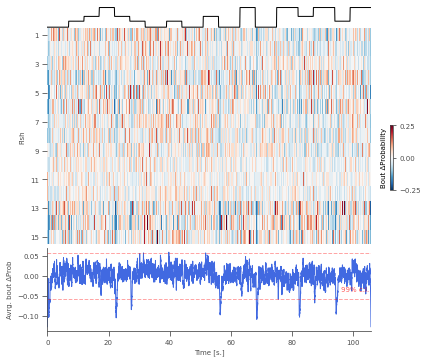

In [17]:
plot_bout_prob(fish_mean_bout_prob, stim_arr, figure=None, frame=None)

### P(bout) decrease time window

In [18]:
#Get timepoints of luminance offsets
offset_timepoints = [(0, 0)]

stim_diff = np.diff(stim_arr[1, :])
for t in range(stim_diff.shape[0]):
    if stim_diff[t]<0 and stim_diff[t-1]==0:
        offset_timepoints.append((t, stim_arr[0, t]))
    else:
        pass

In [19]:
#Crop bout probabilities after luminance offsets
dt = stim_arr[0, :][1]
pre_t_window = .5
t_window = 3

fish_offsets = np.empty((len(offset_timepoints), int((pre_t_window + t_window)/dt), fish_mean_bout_prob.shape[0]))

for fish in range(fish_mean_bout_prob.shape[0]):
    fish_offset_prob = np.empty((len(offset_timepoints), int((pre_t_window + t_window)/dt)))
    
    for offset in range(len(offset_timepoints)):
        if offset_timepoints[offset][0] == 0:
            fish_offset_prob[offset, :int(pre_t_window/dt)] = fish_mean_bout_prob[fish, -int(pre_t_window/dt):]
            fish_offset_prob[offset, int(pre_t_window/dt):] = fish_mean_bout_prob[fish, :int(t_window/dt)]
        else:
            fish_offset_prob[offset, :] = fish_mean_bout_prob[fish, offset_timepoints[offset][0]-int(pre_t_window/dt):offset_timepoints[offset][0]+int(t_window/dt)]
    
    fish_offsets[:, :, fish] = fish_offset_prob

In [20]:
def plot_bout_window(offset_mat, t_window=3, figure=None, frame=None):
    
    if figure is None:
        figure = plt.figure(figsize=(4, 4))
        
    ax = add_offset_axes(figure, (0.15, 0.15, .8, .8), frame=frame) 
    
    t_arr = np.arange(-pre_t_window, t_window, dt)
    for fish in range(fish_offsets.shape[2]):
        ax.plot(t_arr, np.nanmean(fish_offsets[:, :, fish], 0), c='gray', alpha=.5)
    
    ax.plot(t_arr, np.nanmean(np.nanmean(fish_offsets, 0), 1),  c='royalblue', linewidth=2)
    ax.axvline(0, c='black', ls=':', lw=2)
    ax.set_xlim([np.min(t_arr), np.max(t_arr)])
    ax.set_ylabel('Mean bout Δprobability')
    ax.set_xlabel('Time [s.]')

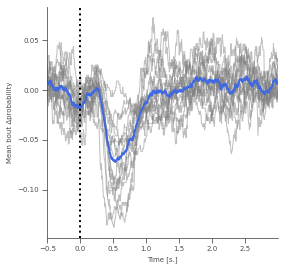

In [21]:
plot_bout_window(fish_offsets)

### Bootstrapping

In [22]:
from random import seed

np.random.seed(572704)
seed(572704)

In [23]:
t_window = 1.5

In [24]:
offset_triggers = [offset_timepoints[i][0] for i in range(len(offset_timepoints))]

#### Bootstrapping for individual fish

In [42]:
#Get REAL bout probabilities after luminance offset for each fish
offset_bout_prob = np.empty((fish_mean_bout_prob.shape[0]))

for fish in range(fish_mean_bout_prob.shape[0]):
    fish_offset_prob = np.empty((len(offset_triggers), int(t_window/dt)))
    
    for offset in range(len(offset_timepoints)):
        fish_offset_prob[offset, :] = fish_mean_bout_prob[fish, offset_triggers[offset]:offset_triggers[offset]+int(t_window/dt)]
    
    offset_bout_prob[fish] = np.nanmean(fish_offset_prob)

In [43]:
#Define number of iterations and matrix to save data
n_iterations = 1000
fake_offset_bout_prob = np.empty((n_iterations, fish_mean_bout_prob.shape[0]))

In [44]:
#Create extended data matrix to avoid issues with datapoints picked from the end of the series
fish_bout_prob_extended = np.empty((fish_mean_bout_prob.shape[0], fish_mean_bout_prob.shape[1]+int(t_window/dt)))

for fish in range(fish_mean_bout_prob.shape[0]):
    fish_bout_prob_extended[fish] = np.append(fish_mean_bout_prob[fish, :], fish_mean_bout_prob[fish, :int(t_window/dt)])

In [45]:
for iteration in range(n_iterations):
    random_triggers = np.random.choice(range(fish_mean_bout_prob.shape[1]), len(offset_triggers), replace=False).tolist()
    
    for fish in range(fish_mean_bout_prob.shape[0]):
        fake_fish_offset_prob = np.empty((len(random_triggers), int(t_window/dt)))
        
        for offset in range(len(random_triggers)):
            fake_fish_offset_prob[offset, :] = fish_bout_prob_extended[fish, random_triggers[offset]:random_triggers[offset]+int(t_window/dt)]
            
        fake_offset_bout_prob[iteration, fish] = np.nanmean(fake_fish_offset_prob)

In [46]:
threshold_prob = 1 #in %

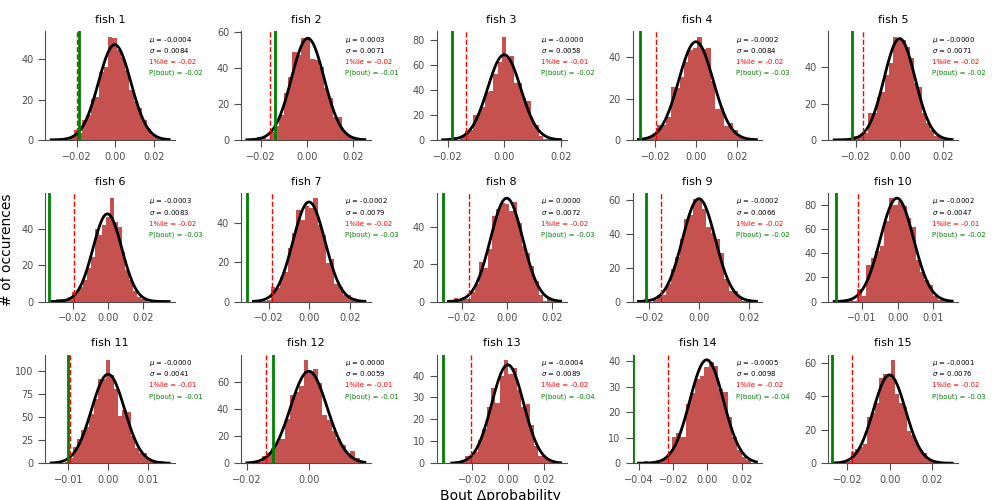

In [47]:
#Plot fish bootstrapped distributions
bootstrapping_fig, axes = plt.subplots(math.ceil(all_fish_mat.shape[2]/5), 5, figsize=(10, 5))
axes = np.ravel(axes)
bootstrap_dict = {fish:{} for fish in range(fish_offsets.shape[2])}

for fish in range(fish_offsets.shape[2]):
    fish_fake_data = fake_offset_bout_prob[:, fish]
    
    #Plot histogram
    axes[fish].set_title('fish {}'.format(fish+1))
    axes[fish].hist(fish_fake_data, bins='auto', density=True)
    
    #Fit normal distribution
    mu, std = stats.norm.fit(fish_fake_data)
    xmin, xmax = axes[fish].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    axes[fish].plot(x, p, 'k', linewidth=2)
    axes[fish].text(.8, .8, '$\mu$ = {:.4f} \n$\sigma$ = {:.4f}'.format(mu, std), fontsize=5, 
                    transform=axes[fish].transAxes)
    
    #Find variable value corresponding to the desired percentile
    threshold_prob = 1 #in %
    lower_bound = stats.norm.ppf(threshold_prob/100, mu, std)
    axes[fish].axvline(lower_bound, c='red', ls='--')
    axes[fish].text(.8, .7, '1%ile = {:.2f}'.format(lower_bound), fontsize=5, color='red', 
                    transform=axes[fish].transAxes, ha='left')

    #Plot actual bout probability
    axes[fish].axvline(offset_bout_prob[fish], c='green', linewidth=2)
    axes[fish].text(.8, .6, 'P(bout) = {:.2f}'.format(offset_bout_prob[fish]), fontsize=5, color='green', 
                    transform=axes[fish].transAxes)
    
    #Save bootstrapping results
    bootstrap_dict[fish]['mu'] = mu
    bootstrap_dict[fish]['std'] = std
    bootstrap_dict[fish]['1ile'] = lower_bound
    bootstrap_dict[fish]['offset_prob'] = offset_bout_prob[fish]

for i_ax, ax in enumerate(axes):
    if i_ax >= fish_offsets.shape[2]:
        ax.axis('off')
        
bootstrapping_fig.text(0.5, 0, 'Bout Δprobability', ha='center')
bootstrapping_fig.text(0., 0.5, '# of occurences', va='center', rotation='vertical')

plt.tight_layout()

#### Bootstrapping for average P(bout)

In [31]:
#Calculate average bout probability during experiment
mean_bout_prob = np.nanmean(fish_mean_bout_prob, 0)

#Get REAL bout probabilities after luminance offset
offset_bout_prob = np.empty((len(offset_triggers), int(t_window/dt)))
    
for offset in range(len(offset_timepoints)):
    offset_bout_prob[offset, :] = mean_bout_prob[offset_triggers[offset]:offset_triggers[offset]+int(t_window/dt)]
    
mean_offset_bout_prob = np.nanmean(np.nanmean(offset_bout_prob, 1), 0)

In [32]:
#Define number of iterations and matrix to save data
n_iterations = 1000
fake_offset_bout_prob = np.empty((n_iterations))

In [33]:
#Create extended data matrix to avoid issues with datapoints picked from the end of the series
mean_bout_prob_extended = np.append(mean_bout_prob, mean_bout_prob[:int(t_window/dt)])

In [34]:
for iteration in range(n_iterations):
    random_triggers = np.random.choice(range(mean_bout_prob.shape[0]), len(offset_triggers), replace=True).tolist()
    
    fake_mean_offset_bout_prob = np.empty((len(random_triggers), int(t_window/dt)))
        
    for offset in range(len(random_triggers)):
        fake_mean_offset_bout_prob[offset, :] = mean_bout_prob_extended[random_triggers[offset]:random_triggers[offset]+int(t_window/dt)]

    fake_offset_bout_prob[iteration] = np.nanmean(fake_mean_offset_bout_prob)

In [35]:
def plot_bootstrap(fake_bout_probs, real_bout_prob, figure=None, frame=None):
    
    if figure is None:
        figure = plt.figure(figsize=(4, 4))
    
    ax = add_offset_axes(figure, (0.15, 0.15, .8, .8), frame=frame)
    
    #Plot histogram
    ax.hist(fake_bout_probs, bins='auto', density=True, color='royalblue')
    
    #Fit normal distribution
    mu, std = stats.norm.fit(fake_bout_probs)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)
    ax.text(.8, .9, '$\mu$ = {:.4f} \n$\sigma$ = {:.4f}'.format(mu, std), fontsize=7.5, 
                    transform=ax.transAxes)
    
    #Find variable value corresponding to the desired percentile
    threshold_prob = 1 #in %
    lower_bound = stats.norm.ppf(threshold_prob/100, mu, std)
    ax.axvline(lower_bound, c='red', ls='--')
    ax.text(lower_bound+0.002, ymax, 'P\u2081 = {:.4f}'.format(lower_bound), fontsize=6, color='red', 
            ha='left', va='top')
    
    #Plot actual bout probability
    ax.axvline(real_bout_prob, c='green', linewidth=2)
    ax.text(mean_offset_bout_prob+0.002, ymax, 'P(bout|offset) \n = {:.4f}'.format(real_bout_prob), fontsize=6, color='green', 
           ha='left', va='top')
    
    ax.set_xlabel('Bout ΔProbability')
    ax.set_ylabel('# of occurences')

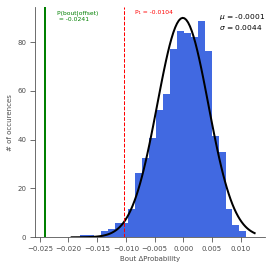

In [36]:
plot_bootstrap(fake_offset_bout_prob, mean_offset_bout_prob)

In [37]:
# def plot_fish_bootstrap(bootstrapping_dict, figure=None, frame=None):
    
#     if figure is None:
#         figure = plt.figure(figsize=(6, 1.5))
    
#     ax = add_offset_axes(figure, (0.15, 0.25, 0.8, 0.7), frame=frame)

#     fish_diff = []
#     colors = []
#     for fish in bootstrap_dict.keys():
#         difference = bootstrapping_dict[fish]['offset_prob'] - bootstrapping_dict[fish]['1ile']
#         fish_diff.append(difference)
#         if difference < 0:
#             colors.append('green')
#         else:
#             colors.append('red')
        
#     ax.scatter(np.arange(1, 16), fish_diff, color=colors)
#     ax.axhline(0, ls='--', c='black', alpha=.5)
    
#     ax.set_xlabel('Fish')
#     ax.set_ylabel('P(bout|offset) - P\u2081')

In [38]:
def plot_fish_bootstrap(bootstrapping_dict, figure=None, frame=None):
    
    if figure is None:
        figure = plt.figure(figsize=(2, 3))
    
    c_pal_cols = ['red', 'grass green']
    c_pal = sns.xkcd_palette(c_pal_cols)
    
    ax = add_offset_axes(figure, (0.5, 0.05, 0.5, 0.9), frame=frame)

    fish_diff = []
    colors = []
    for fish in bootstrap_dict.keys():
        difference = bootstrapping_dict[fish]['offset_prob'] - bootstrapping_dict[fish]['1ile']
        fish_diff.append(difference)
        if difference < 0:
            colors.append('green')
        else:
            colors.append('red')
    
    x_pos = np.random.normal(1, .0025, len(fish_diff))
    g = sns.swarmplot(x=np.full(len(fish_diff), 1), y=fish_diff, hue=colors, palette=c_pal)
    ax.legend().remove()
    ax.axhline(0, ls='--', c='black', alpha=.5)
    
    ax.set_xticks([])
    ax.set_ylabel('P(bout|offset) - P\u2081')
    ax.spines['bottom'].set_visible(False)

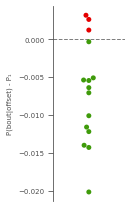

In [39]:
plot_fish_bootstrap(bootstrap_dict)

### Assemble figure

In [ ]:
figureS7 = plt.figure(figsize=(7, 9))

#Bout prob plot:
bout_prob_panel = plot_bout_prob(fish_mean_bout_prob, stim_arr, figure=figureS7, frame=(0.01, 0.4, 1, 0.65))
figureS7.text(0.01, 0.95, 'A')

#Bout prob window plot:
bout_prob_win_panel = plot_bout_window(fish_offsets, figure=figureS7, frame=(0.025, 0.05, 0.4, 0.35))
figureS7.text(0.005, 0.375, 'B')

#Bootstrapping of average P(bout):
avg_bootstrap_panel = plot_bootstrap(fake_offset_bout_prob, mean_offset_bout_prob, figure=figureS7, frame=(0.425, 0.05, 0.4, 0.35))
figureS7.text(0.425, 0.375, 'C')

#Individual fish bootstrapping:
fish_bootstrap_panel = plot_fish_bootstrap(bootstrap_dict, figure=figureS7, frame=(0.885, 0.1, 0.125, 0.3))
figureS7.text(0.85, 0.375, 'D')

In [ ]:
if fig_fold is not None:
    figureS7.savefig(str(fig_fold / "fig1_supplementary.pdf"))